In [127]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import time
import datetime

pandas.set_option('display.max_columns', 200)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Предобработка данных

In [128]:
train = pandas.read_csv('features.csv', index_col='match_id')
train.describe().head(10)

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,77677.000000,77677.000000,77677.000000,53243.000000,81539.000000,96538.000000,69751.000000,97230.000000,97230.000000,97230.000000,97230.000000,95394.000000,81087.000000,96554.000000,71132.000000,97230.000000,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,52.183452,3.364661,1189.223676,1107.863993,10.471747,0.348709,0.363550,8.275584,52.710491,3.353924,1182.879965,1099.643742,10.333004,0.342723,0.357338,8.273527,52.648092,3.308896,1159.088481,1082.090240,9.981909,0.337746,0.357307,8.275049,52.625630,3.304237,1158.586167,1082.057061,9.995351,0.337262,0.352782,8.288491,51.990106,3.461123,1238.855765,1151.018184,11.253841,0.372262,0.344091,8.296380,52.708547,3.388933,1199.858809,1108.633436,10.460424,0.356238,0.347012,8.310419,52.755137,3.378638,1193.554438,1103.273702,10.386918,0.353533,0.347732,8.305420,52.922421,3.337725,1171.952155,1088.711653,10.035349,0.354952,0.341860,8.319665,53.059694,3.345274,1177.395351,1089.558850,10.053739,0.356063,0.342538,8.323048,97.688029,0.521815,4.593483,4.383224,126.800255,-80.059510,215.987126,2.994775,3.312527,2.431719,0.716250,-6.875747,127.215028,-80.191893,214.870536,2.965566,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,32.674077,1.097536,555.363510,458.001007,8.972073,0.654060,0.624236,2.433864,32.560923,1.092126,554.899600,454.727127,8.950871,0.647774,0.618071,2.440139,32.670519,1.092502,550.937530,450.353291

Целевой переменной является "radiant_win"

In [129]:
#Посчитаем в каких столбцах cколько пропусков
rows = train.shape[0]
counts = train.count()
counts_nan = counts[counts < rows]
counts_nan.sort_values().apply(lambda c: float((rows - c) * 100 / rows))

first_blood_player2            45.240152
radiant_flying_courier_time    28.261853
dire_flying_courier_time       26.841510
first_blood_time               20.110048
first_blood_team               20.110048
first_blood_player1            20.110048
dire_bottle_time               16.602900
radiant_bottle_time            16.138023
radiant_first_ward_time         1.888306
dire_first_ward_time            1.878021
radiant_courier_time            0.711714
dire_courier_time               0.695259
dtype: float64

#### Обоснование пропусков:
* first_blood_player2 (второй игрок, причастный к событию) - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев
* first_blood_time (игровое время первой крови) - в 20% случаев первой крови нет в первые 5 минут игры
* radiant_flying_courier_time (время приобретения предмета "flying_courier") - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры

Остальные признаки аналогичны

In [130]:
#Замена пропусков
train = train.fillna(0).astype('int')

In [131]:
# удаление итогов матча
totals = ['duration', 
          'tower_status_radiant', 
          'tower_status_dire',
          'barracks_status_radiant',
          'barracks_status_dire',]
for total in totals:
    del train[total]

In [132]:
# запись целевой переменной
y_train = train['radiant_win']
del train['radiant_win']

In [133]:
# удаление категориальных признаков
X_train = train.copy()
del X_train['lobby_type']
for i in range(1, 6):
    del X_train[f'r{i}_hero']
    del X_train[f'd{i}_hero']

## Градиентный бустинг

In [134]:
nums = (10, 20, 30, 80, 130, 230, 330)
scores = []
for n in nums:
    print(f"# {n}", end='\t')
    model = GradientBoostingClassifier(n_estimators=n, random_state=42)
    start_time = datetime.datetime.now()
    cvl = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kf)
    print(f"Time: {datetime.datetime.now() - start_time}")
    scores.append(cvl.mean())

# 10	Time: 0:00:18.778186
# 20	Time: 0:00:31.117726
# 30	Time: 0:00:44.798115
# 80	Time: 0:01:57.903476
# 130	Time: 0:03:19.705565
# 230	Time: 0:05:41.598874
# 330	Time: 0:08:05.029970


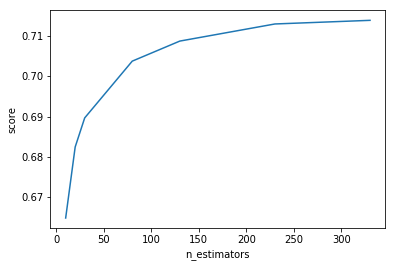

In [135]:
plt.plot(nums, scores)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

#### Результаты:
Показатель метрики качества AUC-ROC равен 0.69 для градиентного бустинга с 30 деревьями, по времени это заняло 0:00:47. Увеличение количества деревьев до 200~ дает площадь порядка 0.71, дальше увеличение количества деревьев практически не улучшает результат, он стремится к 0.72
##### Для улучшения результатов модели / ускорения обучения можно:
* Уменьшить размерность, избавившись от линейно-зависимых и ненужных признаков
* Использовать не всю выборку, а некоторое ее подмножество, деревья малочувствительны к размеру. 
* Уменьшить глубину деревьев, в градиентном бустинге в отличие от случайного леса нам важна ширина.
* Использовать стохастический градиентный бустинг, в нем случайные подвыборки.

## Логистическая регрессия

In [165]:
def best_C(X, Cs):
    scores = []
    text = []
    for C in Cs:
        start_time = datetime.datetime.now()
        model = LogisticRegression(C=C, random_state=42)
        cvs = cross_val_score(model, X, y_train, cv=kf, scoring='roc_auc')
        start_time = datetime.datetime.now() - start_time
        text.append(f'C={C:.5f}, AUC-ROC={cvs.mean():.4f}, time={start_time}')
        scores.append(cvs.mean())
    return scores, text

In [170]:
def pl(ans, range_):
    plt.plot(range_, ans)
    plt.xlabel('lg(C)')
    plt.ylabel('score')
    plt.show()

In [167]:
# X_train = train этой строкой можно проверить влияют ли на модель категориальные данные
X_train = StandardScaler().fit_transform(X_train)

In [168]:
range_ = range(-5, 6)
C_range = (10**i for i in range_)
'''
Для получения более точного значения С
range_ = range(1, 11)
C_range = (i/1000 for i in range_)
'''
ans = best_C(X_train, C_range)
print(*ans[1], sep='\n')

C=0.00001, AUC-ROC=0.6951, time=0:00:02.787538
C=0.00010, AUC-ROC=0.7113, time=0:00:04.219708
C=0.00100, AUC-ROC=0.7164, time=0:00:07.577721
C=0.01000, AUC-ROC=0.7166, time=0:00:09.668128
C=0.10000, AUC-ROC=0.7165, time=0:00:10.967651
C=1.00000, AUC-ROC=0.7165, time=0:00:10.806079
C=10.00000, AUC-ROC=0.7165, time=0:00:10.956679
C=100.00000, AUC-ROC=0.7165, time=0:00:11.066385
C=1000.00000, AUC-ROC=0.7165, time=0:00:11.120240
C=10000.00000, AUC-ROC=0.7165, time=0:00:12.033797
C=100000.00000, AUC-ROC=0.7165, time=0:00:11.346635


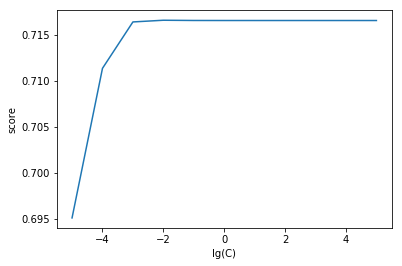

In [171]:
pl(ans[0], range_)

##### Вывод:
Площадь при С=0.01 примерно 0.716. Наилучшее значение показателя AUC-ROC так же достигается при C = 0.007 и равно 0.717. Так же при проверке модели с категориальными признаками получается такой же результат, значит модель распознает их как шум.

Надо заметить, что метрика AUC-ROC данной модели примерно равна 330 деревьям в градиентном бустинге, но при этом в разы быстрее.

##### Мешок слов

In [174]:
def bag_words(all_, X_):
    X_hero = numpy.zeros((all_.shape[0], 112))
    for i, match_id in enumerate(all_.index):
        for p in range(1, 6):
            X_hero[i, all_.ix[match_id, f'r{p}_hero']-1] = 1
            X_hero[i, all_.ix[match_id, f'd{p}_hero']-1] = -1
    X_ = pandas.DataFrame(X_)
    X_hero = pandas.DataFrame(X_hero)
    return pandas.concat([X_, X_hero], axis=1)

In [209]:
mx = 0
for i in range(1, 6):
    mx = max(max(train[f'r{i}_hero']), max(train[f'd{i}_hero']), mx)
print(mx)  # количество героев в выборке

112


In [175]:
# Формируем "мешок слов" по героям 
X_train = bag_words(train, X_train)

C:\Users\valer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\valer\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [176]:
range_ = range(-5, 6)
C_range = (10**i for i in range_)
'''
Для получения более точного значения С
range_ = range(5, 15)
C_range = (i/10 for i in range_)
'''
ans = best_C(X_train, C_range)
print(*ans[1], sep='\n')

C=0.00001, AUC-ROC=0.6992, time=0:00:03.632277
C=0.00010, AUC-ROC=0.7251, time=0:00:05.092369
C=0.00100, AUC-ROC=0.7463, time=0:00:10.319385
C=0.01000, AUC-ROC=0.7517, time=0:00:16.806024
C=0.10000, AUC-ROC=0.7519, time=0:00:23.956889
C=1.00000, AUC-ROC=0.7519, time=0:00:27.830526
C=10.00000, AUC-ROC=0.7519, time=0:00:24.392721
C=100.00000, AUC-ROC=0.7519, time=0:00:24.880416
C=1000.00000, AUC-ROC=0.7519, time=0:00:23.819258
C=10000.00000, AUC-ROC=0.7519, time=0:00:24.659009
C=100000.00000, AUC-ROC=0.7519, time=0:00:23.171987


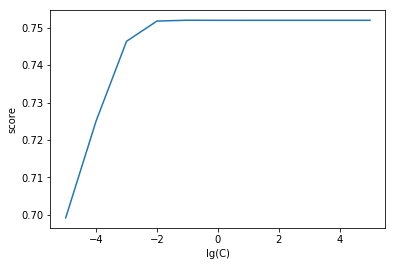

In [177]:
pl(ans[0], range_)

#### Результаты:
После добавления "мешка слов" по героям площадь увеличилась. Наилучшее значение показателя AUC-ROC = 0.75 достигается при C = 0.1. Это произошло, потому что вместо отсутствия данных или шума, мы имеем осмысленную разреженную матрицу для построения предсказания.

## Предсказание для тестовой выборки:

In [204]:
test = pandas.read_csv('features_test.csv',index_col='match_id')
#Замена пропусков
test = test.fillna(0).astype('int')
# удаление категориальных признаков
X_test = test.copy()
del X_test['lobby_type']
for i in range(1, 6):
    del X_test[f'r{i}_hero']
    del X_test[f'd{i}_hero']
X_test = StandardScaler().fit_transform(X_test)
X_test = bag_words(test, X_test)

C:\Users\valer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\valer\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [205]:
clf = LogisticRegression(C=0.1)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]

In [206]:
print(min(pred), max(pred))

0.008580489283139484 0.9964592489915288
